In [68]:
import folium
import branca
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
import holidays
from sklearn.linear_model import LinearRegression
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [69]:
# df_2005_2007 = pd.read_csv('modified_data_2006_2008.csv')
# df_2009_2011 = pd.read_csv('accidents_2009_to_2011.csv')
df_2012_2014 = pd.read_csv('accidents_2012_to_2014.csv')
df_combined = pd.concat([df_2012_2014], ignore_index=True)

In [70]:
filtered_df = df_combined[df_combined['LSOA_of_Accident_Location']=='E01004736']
print(filtered_df[['Longitude', 'Latitude']])
longitude_mean = filtered_df['Longitude'].mean()
longitude_range = [longitude_mean - 0.1, longitude_mean + 0.4]
print(longitude_range)
latitude_mean = filtered_df['Latitude'].mean()
latitude_range = [latitude_mean - 0.05, latitude_mean + 0.05]
print(latitude_range)

        Longitude   Latitude
994     -0.127093  51.506075
995     -0.130856  51.505685
998     -0.128770  51.507361
1010    -0.126964  51.505713
1024    -0.144097  51.506076
...           ...        ...
321012  -0.133003  51.509587
321016  -0.149719  51.502478
321027  -0.133560  51.510045
321038  -0.122759  51.506366
336204  -0.123043  51.506460

[460 rows x 2 columns]
[-0.23280405217391287, 0.26719594782608713]
[51.45667469782614, 51.55667469782613]


In [71]:
df_E01004736 = df_combined[(df_combined['Longitude'] >= longitude_range[0])
                           &(df_combined['Longitude'] <= longitude_range[1])
                           &(df_combined['Latitude'] >= latitude_range[0])
                           &(df_combined['Latitude'] <= latitude_range[1])]

In [72]:
df_E01004736 = df_E01004736[(df_E01004736['Year']==2012) & (df_E01004736['Number_of_Casualties']>2)]
#location is the mean of every lat and long point to centre the map.
location = df_E01004736['Latitude'].mean(), df_E01004736['Longitude'].mean()

zoom_start = 12
#A basemap is then created using the location to centre on and the zoom level to start.
m = folium.Map(location=location,zoom_start=zoom_start)

#Each location in the DataFrame is then added as a marker to the basemap points are then added to the map
for i in range(0,len(df_E01004736)):
    folium.Marker([df_E01004736['Latitude'].iloc[i],df_E01004736['Longitude'].iloc[i]]).add_to(m)
        
m


In [95]:
import folium.plugins as plugins

data_heat = df_E01004736[['Latitude','Longitude','Number_of_Casualties']].values.tolist()
m = folium.Map(location=location, zoom_start=zoom_start)
#tiles='stamentoner'

plugins.HeatMap(data_heat, min_opacity=0.6, radius=15, blur=10).add_to(m)

m

In [74]:
import geopandas as gpd

# Load the shapefile
shapefile_path = 'greater-london-latest-free.shp/gis_osm_landuse_a_free_1.shp'  # Replace with your actual path
landuse = gpd.read_file(shapefile_path)
unique_land_use_types = landuse['fclass'].unique()

# Inspect the first few rows to see the data
print(unique_land_use_types)
landuse.head()


['park' 'nature_reserve' 'forest' 'industrial' 'retail'
 'recreation_ground' 'meadow' 'residential' 'cemetery' 'grass' 'scrub'
 'allotments' 'quarry' 'commercial' 'military' 'heath' 'farmland'
 'farmyard' 'orchard']


,osm_id,code,fclass,name,geometry
0,2838058,7202,park,NaN,"POLYGON ((-0.09186 51.66414, -0.09146 51.66418..."
1,2903046,7202,park,NaN,"POLYGON ((-0.08025 51.66596, -0.08005 51.66690..."
2,2903368,7202,park,St Michael's Green,"POLYGON ((-0.08655 51.66212, -0.08653 51.66293..."
3,2903369,7202,park,NaN,"POLYGON ((-0.08272 51.66104, -0.08238 51.66179..."
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07065 51.64713, -0.07058 51.64751..."


In [75]:
from shapely.geometry import box

# Get the bounds from df_E01004736
min_longitude = df_E01004736['Longitude'].min()
max_longitude = df_E01004736['Longitude'].max()
min_latitude = df_E01004736['Latitude'].min()
max_latitude = df_E01004736['Latitude'].max()

# Create a bounding box for the area of interest using shapely's box
bounding_box = gpd.GeoDataFrame({
    'geometry': [box(min_longitude, min_latitude, max_longitude, max_latitude)]
})

In [94]:
shapefile_path_1 = f"greater-london-latest-free.shp/gis_osm_pois_a_free_1.shp"
df_1 = gpd.read_file(shapefile_path_1)
df_1.head(10)

,osm_id,code,fclass,name,geometry
0,2534762,2252,pitch,NaN,"POLYGON ((-0.14330 51.35536, -0.14313 51.35558..."
1,2838058,2204,park,NaN,"POLYGON ((-0.09186 51.66414, -0.09146 51.66418..."
2,2903046,2204,park,NaN,"POLYGON ((-0.08025 51.66596, -0.08005 51.66690..."
3,2903368,2204,park,St Michael's Green,"POLYGON ((-0.08655 51.66212, -0.08653 51.66293..."
4,2903369,2204,park,NaN,"POLYGON ((-0.08272 51.66104, -0.08238 51.66179..."
5,2903398,2204,park,Bush Hill Park,"POLYGON ((-0.07065 51.64713, -0.07058 51.64751..."
6,2914274,2204,park,Stephens House & Grounds,"POLYGON ((-0.19549 51.59656, -0.19545 51.59679..."
7,2926821,2204,park,Oakwood Park,"POLYGON ((-0.12626 51.64160, -0.12625 51.64196..."
8,2939009,2204,park,Enfield Town Park,"POLYGON ((-0.08908 51.64875, -0.08905 51.64884..."
9,2939140,2204,park,Victoria Recreation Ground,"POLYGON ((-0.17268 51.65330, -0.17253 51.65331..."


In [76]:
def style_function_basic(feature):
   return {
      'fillColor': 'skyblue',
      'color': 'black',
      'weight': 0,
      'fillOpacity': 0.5
   }

In [77]:
# Define a style function for land use features
def style_function_landuse(feature):
    land_use_type = feature['properties']['fclass']
    
    # Define colors based on land use type
    colors = {
        'park': 'green',
        'recreation_ground': 'green',
        'nature_reserve': 'darkgreen',
        'forest': 'green',
        'residential': 'yellow',
        'commercial': 'red',
        'industrial': 'purple',
        'retail': 'orange'
    }
    
    # Set dark gray for any other land use types
    return {
        'fillColor': colors.get(land_use_type, 'darkgray'),  # Default to dark gray if not specified
        'color': 'transparent',
        'weight': 0,
        'fillOpacity': 0.6
    }



In [91]:
import folium
import folium.plugins as plugins
import geopandas as gpd

def gis_shp(urban_element_1, style_function_1, urban_element_2, style_function_2, urban_element_3, style_function_3, df_casualties):
    # Load the first shapefile
    shapefile_path_1 = f"greater-london-latest-free.shp/gis_osm_{urban_element_1}_a_free_1.shp"
    df_1 = gpd.read_file(shapefile_path_1)

    # Load the second shapefile
    shapefile_path_2 = f"greater-london-latest-free.shp/gis_osm_{urban_element_2}_a_free_1.shp"
    df_2 = gpd.read_file(shapefile_path_2)

    # Load the third shapefile
    shapefile_path_3 = f"greater-london-latest-free.shp/gis_osm_{urban_element_3}_a_free_1.shp"
    df_3 = gpd.read_file(shapefile_path_3)

    # Ensure all DataFrames are in the same CRS (Coordinate Reference System)
    df_1 = df_1.set_crs(epsg=4326)
    df_2 = df_2.set_crs(epsg=4326)
    df_3 = df_3.set_crs(epsg=4326)

    # Step 1: Filter the land use data to include only those that intersect with the bounding box
    filtered_df_1 = df_1[df_1.intersects(bounding_box.geometry[0])]
    filtered_df_2 = df_2[df_2.intersects(bounding_box.geometry[0])]
    filtered_df_3 = df_3[df_3.intersects(bounding_box.geometry[0])]

    # Create the base map
    m = folium.Map(location=location, zoom_start=zoom_start, tiles=None)  # Set tiles=None to hide the base map

    # Step 2: Add the first urban element
    folium.GeoJson(
        filtered_df_1.__geo_interface__,
        name=urban_element_1,
        style_function=style_function_1,
        tooltip=folium.GeoJsonTooltip(fields=['fclass'], aliases=[f'{urban_element_1}:'], localize=True)
    ).add_to(m)

    # Add the second urban element
    folium.GeoJson(
        filtered_df_2.__geo_interface__,
        name=urban_element_2,
        style_function=style_function_2,
        tooltip=folium.GeoJsonTooltip(fields=['fclass'], aliases=[f'{urban_element_2}:'], localize=True)
    ).add_to(m)

    # Add the third urban element
    folium.GeoJson(
        filtered_df_3.__geo_interface__,
        name=urban_element_3,
        style_function=style_function_3,
        tooltip=folium.GeoJsonTooltip(fields=['fclass'], aliases=[f'{urban_element_3}:'], localize=True)
    ).add_to(m)

    # Step 3: Prepare the heatmap data
    data_heat = df_casualties[['Latitude', 'Longitude', 'Number_of_Casualties']].values.tolist()
    
    # Add the heatmap layer on top
    heatmap = plugins.HeatMap(data_heat, min_opacity=0.5, radius=15, blur=10)
    m.add_child(heatmap)  # Ensure the heatmap is added as a child of the map

    # Add a layer control to toggle between the layers
    folium.LayerControl().add_to(m)

    # Display the map
    m.save(f'accidents_heatmap_with_filtered_{urban_element_1}_{urban_element_2}_{urban_element_3}.html')
    return m

# Call the modified gis_shp function with both urban elements, their style functions, and the casualties DataFrame
gis_shp(
    'water', style_function_basic, 
    'landuse', style_function_landuse, 
    'railways', style_function_basic, 
    df_E01004736  # Your DataFrame containing casualties
)


AssertionError: The field fclass is not available in the data. Choose from: ().

## Prediction

In [27]:
def EDA_cause(df,cause, resample):
   df_cause = df.groupby('Date', as_index=False)[cause].sum()
   df_cause['Date'] = pd.to_datetime(df_cause['Date'], dayfirst=True)  # dayfirst=True if your dates are in DD/MM/YYYY format

   # Sort by 'Date'
   df_cause = df_cause.sort_values(by='Date')

   # Set the DateTime column as the index
   df_cause.set_index('Date', inplace=True)

   # Resample the data by day, taking the mean number of vehicles
   df_cause_daily = df_cause.resample(resample).mean()

   # Plot the number of vehicles over time
   plt.figure(figsize=(12, 4))
   plt.plot(df_cause_daily.index, df_cause_daily, label=cause)
   plt.title(f"{cause} Over Time")
   plt.xlabel('Date')
   plt.ylabel('cause')
   plt.legend()
   plt.show()

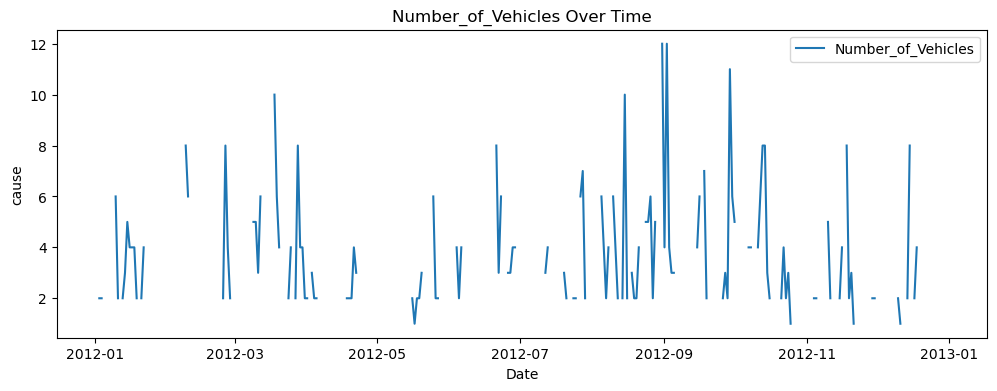

In [28]:
EDA_cause(df_E01004736,'Number_of_Vehicles','d')

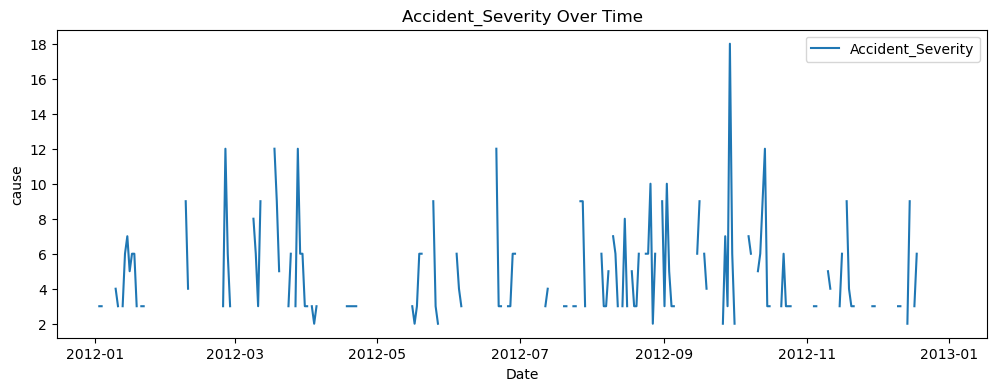

In [29]:
EDA_cause(df_E01004736,'Accident_Severity','d')

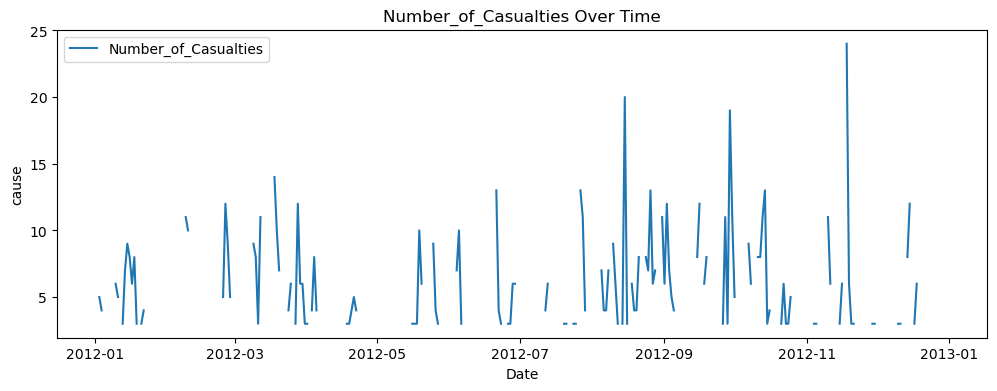

In [30]:
EDA_cause(df_E01004736,'Number_of_Casualties','d')